In [2]:

# Cell 1: INSTALLATION

!pip uninstall -q -y numpy pandas tensorflow-model-optimization jax jaxlib flax

!pip install -q "numpy==1.26.4" "pandas==2.2.2" librosa pydub tensorflow-model-optimization seaborn soundfile

print("\n---  INSTALLATION FINISHED ---")
print(" 1. Look at the top of your screen.")
print(" 2. Click 'Runtime' -> 'Restart session'.")
print(" 3. AFTER it restarts, run the code block below (PART B).")


import os
import pathlib
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
from tensorflow.keras import layers, models


warnings.filterwarnings('ignore')

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print("\n--- ✅ Environment Configured Successfully ---")
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version:      {np.__version__} (Verified: 1.26.4)")
print(f"Pandas Version:     {pd.__version__}")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.90 requires jax>=0.4.27, which is not installed.
chex 0.1.90 requires jaxlib>=0.4.27, which is not installed.
orbax-checkpoint 0.11.31 requires jax>=0.6.0, which is not installed.
optax 0.2.6 requires jax>=0.5.3, which is not installed.
optax 0.2.6 requires jaxlib>=0.5.3, which is not installed.
dopamine-rl 4.1.2 requires flax>=0.2.0, which is not installed.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires jaxlib>=0.1.51, which is not installed.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 r

2428923189/2428923189 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step
 Extracting dataset... This may take a minute.
 Extraction Complete.


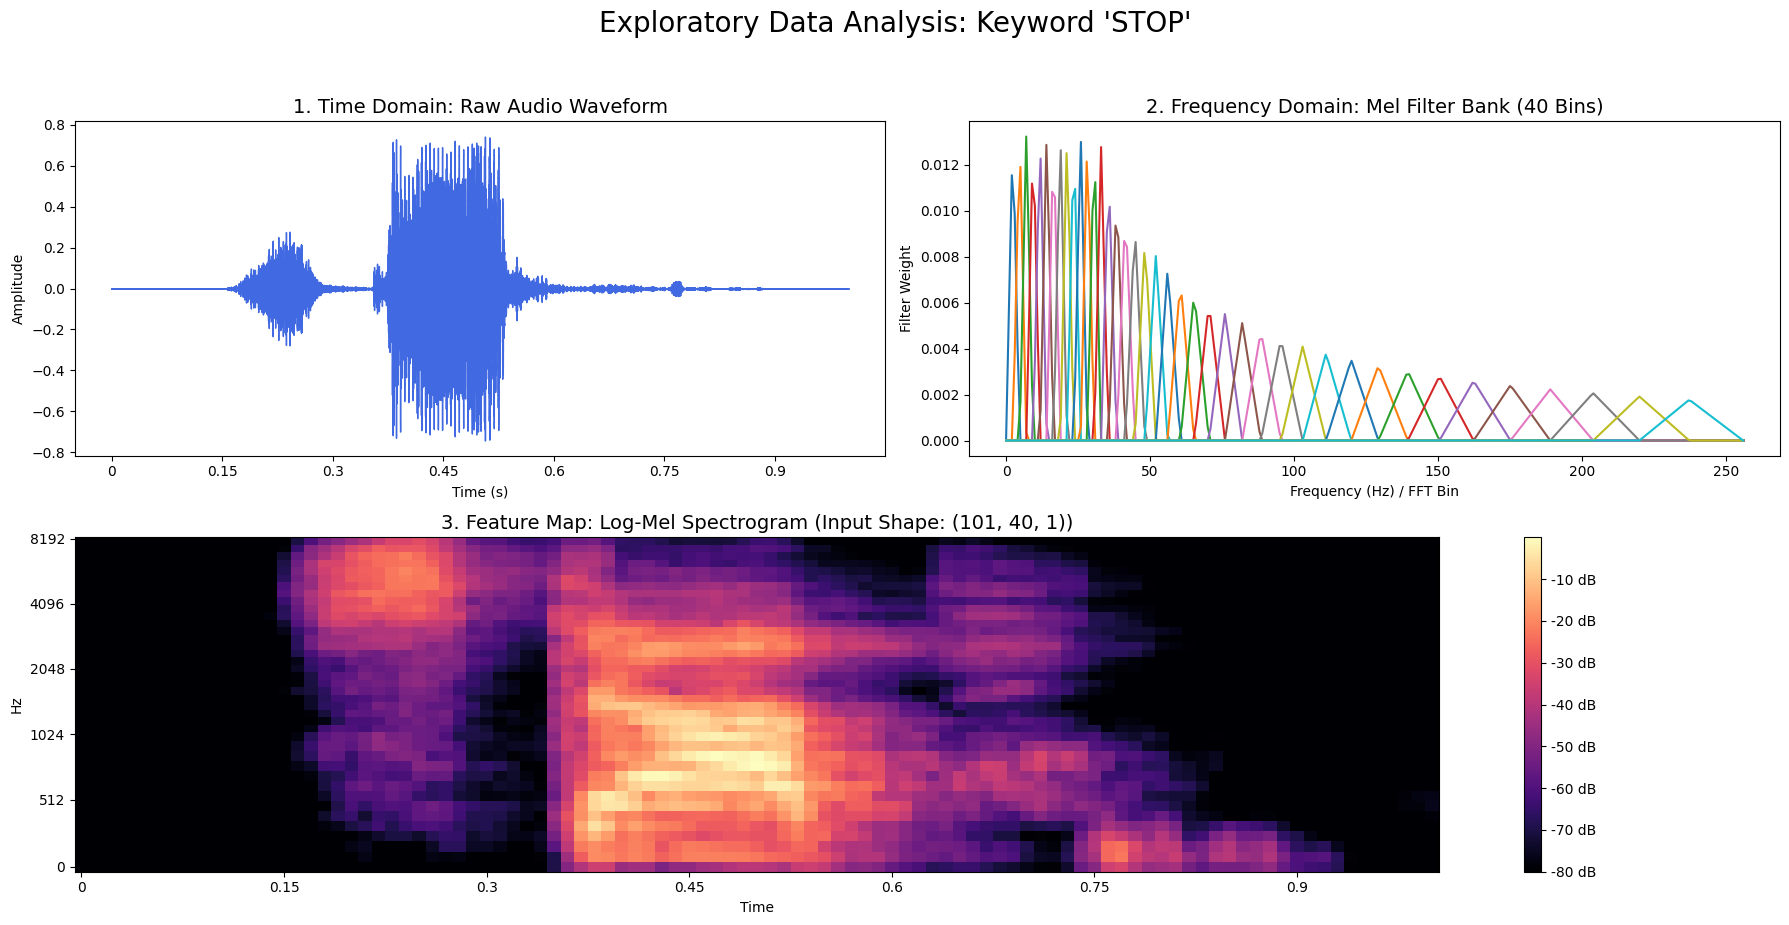

In [3]:

# CELL 2: Configuration, Data Selection, and Visualizations (EDA)

import tarfile

class Config:
    # 1. Dataset Parameters
    DATA_URL = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
    DATA_DIR = pathlib.Path('data/speech_commands')


    TARGET_KEYWORDS = ['stop', 'go']
    ALL_CLASSES = TARGET_KEYWORDS + ['unknown', 'silence']
    NUM_CLASSES = len(ALL_CLASSES)

    SAMPLE_RATE = 16000
    DURATION = 1.0
    AUDIO_LENGTH = int(SAMPLE_RATE * DURATION)

    N_MELS = 40
    N_FFT = 512
    HOP_LENGTH = 160
    FMIN = 20
    FMAX = 8000
    SPECTROGRAM_SHAPE = (101, 40, 1)

if not Config.DATA_DIR.exists():
    print(" Downloading Google Speech Commands v0.02 (approx 2.4GB)...")

    archive = tf.keras.utils.get_file(
        'speech_commands_v2.tar.gz',
        origin=Config.DATA_URL,
        extract=False,
        cache_dir='.',
        cache_subdir='data'
    )

    print(" Extracting dataset... This may take a minute.")
    Config.DATA_DIR.mkdir(parents=True, exist_ok=True)
    with tarfile.open(archive, 'r:gz') as tar:
        tar.extractall(path=Config.DATA_DIR)
    print(" Extraction Complete.")
else:
    print(f" Dataset already located at: {Config.DATA_DIR}")

def visualize_audio_features(keyword):
    """
    Generates a professional three-part analysis of a keyword:
    Waveform, Mel Filter Bank, and Log-Mel Spectrogram.
    """

    keyword_dir = Config.DATA_DIR / keyword
    sample_file = next(keyword_dir.glob('*.wav'))
    y, sr = librosa.load(sample_file, sr=Config.SAMPLE_RATE)

    plt.figure(figsize=(18, 10))
    plt.suptitle(f"Exploratory Data Analysis: Keyword '{keyword.upper()}'", fontsize=20, y=0.95)

    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y, sr=sr, color='royalblue')
    plt.title("1. Time Domain: Raw Audio Waveform", fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")


    plt.subplot(2, 2, 2)
    mel_fb = librosa.filters.mel(sr=Config.SAMPLE_RATE, n_fft=Config.N_FFT, n_mels=Config.N_MELS)
    for i in range(mel_fb.shape[0]):
        plt.plot(mel_fb[i])
    plt.title("2. Frequency Domain: Mel Filter Bank (40 Bins)", fontsize=14)
    plt.xlabel("Frequency (Hz) / FFT Bin")
    plt.ylabel("Filter Weight")


    plt.subplot(2, 1, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=Config.N_MELS,
                                       n_fft=Config.N_FFT, hop_length=Config.HOP_LENGTH)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel',
                                   sr=sr, hop_length=Config.HOP_LENGTH, fmax=Config.FMAX)
    plt.title(f"3. Feature Map: Log-Mel Spectrogram (Input Shape: {Config.SPECTROGRAM_SHAPE})", fontsize=14)
    plt.colorbar(img, format='%+2.0f dB')

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

visualize_audio_features('stop')

 Found 3872 samples for target: stop
 Found 3880 samples for target: go
 Collected 'unknown' samples from 33 other categories.
 Generated 396 'silence' segments from background noise.


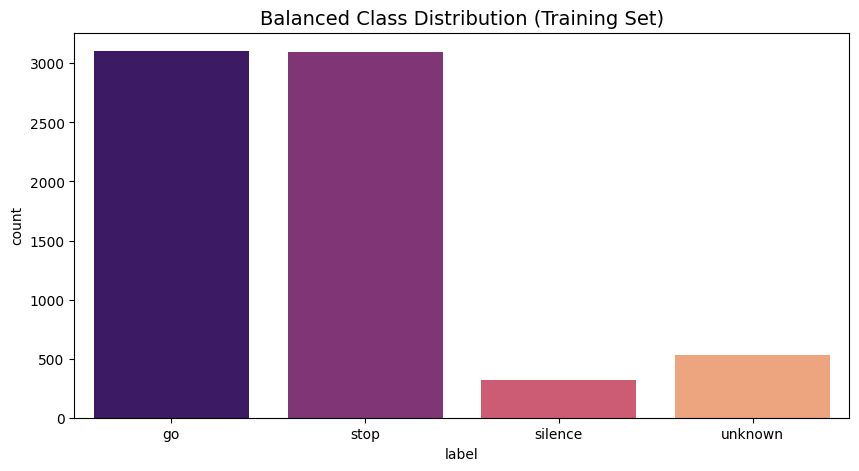


 Total Dataset size: 8808
--- Training:   7046
--- Validation: 881
--- Testing:    881


In [4]:

# CELL 3: Data Selection, Background Noise Slicing, and Robust Splitting

from sklearn.model_selection import train_test_split

def prepare_kws_dataframe(data_dir, config):
    all_paths = []
    all_labels = []

    # 1. Add Target Keywords (Stop, Go)
    for label in config.TARGET_KEYWORDS:
        folder = data_dir / label
        files = list(folder.glob('*.wav'))
        all_paths.extend([str(f) for f in files])
        all_labels.extend([label] * len(files))
        print(f" Found {len(files)} samples for target: {label}")


    other_folders = [d.name for d in data_dir.iterdir() if d.is_dir()
                     and d.name not in config.TARGET_KEYWORDS
                     and not d.name.startswith('_')]

    for label in other_folders:
        folder = data_dir / label
        files = list(folder.glob('*.wav'))
        np.random.shuffle(files)
        selected = files[:20]
        all_paths.extend([str(f) for f in selected])
        all_labels.extend(['unknown'] * len(selected))

    print(f" Collected 'unknown' samples from {len(other_folders)} other categories.")


    silence_folder = data_dir / '_background_noise_'
    background_files = list(silence_folder.glob('*.wav'))

    silence_count = 0
    for bg_file in background_files:
        if 'README' in bg_file.name: continue
        y, sr = librosa.load(bg_file, sr=config.SAMPLE_RATE)

        for i in range(0, len(y) - config.AUDIO_LENGTH, config.AUDIO_LENGTH):
            if silence_count >= 500: break
            segment = y[i : i + config.AUDIO_LENGTH]

            os.makedirs('data/silence_clips', exist_ok=True)
            clip_path = f'data/silence_clips/silence_{silence_count}.wav'
            librosa.output.write_wav(clip_path, segment, sr) if hasattr(librosa, 'output') else sf.write(clip_path, segment, sr)
            all_paths.append(clip_path)
            all_labels.append('silence')
            silence_count += 1

    print(f" Generated {silence_count} 'silence' segments from background noise.")


    df = pd.DataFrame({'path': all_paths, 'label': all_labels})
    return df


import soundfile as sf


df = prepare_kws_dataframe(Config.DATA_DIR, Config)


label_to_id = {label: i for i, label in enumerate(Config.ALL_CLASSES)}
df['label_id'] = df['label'].map(label_to_id)

train_df, temp_df = train_test_split(
    df, train_size=0.8, random_state=SEED, stratify=df['label']
)


val_df, test_df = train_test_split(
    temp_df, train_size=0.5, random_state=SEED, stratify=temp_df['label']
)


plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='label', palette='magma')
plt.title("Balanced Class Distribution (Training Set)", fontsize=14)
plt.show()

print(f"\n Total Dataset size: {len(df)}")
print(f"--- Training:   {len(train_df)}")
print(f"--- Validation: {len(val_df)}")
print(f"--- Testing:    {len(test_df)}")

In [5]:

# CELL 4: Unified Configuration
import pathlib
import numpy as np
import tensorflow as tf

class Config:
    """Consolidated configuration to prevent AttributeErrors and NameErrors"""

    DATA_DIR = pathlib.Path('data/speech_commands')


    TARGET_KEYWORDS = ['stop', 'go']
    UNKNOWN_LABEL = 'unknown'
    SILENCE_LABEL = 'silence'
    ALL_CLASSES = TARGET_KEYWORDS + [UNKNOWN_LABEL, SILENCE_LABEL]
    NUM_CLASSES = len(ALL_CLASSES)

    SAMPLE_RATE = 16000
    AUDIO_DURATION = 1.0
    AUDIO_LENGTH = 16000
    N_MELS = 40
    N_FFT = 512
    HOP_LENGTH = 160
    SPECTROGRAM_SHAPE = (101, 40, 1)

    BATCH_SIZE = 32
    EPOCHS = 30
    LEARNING_RATE = 0.001
    EARLY_STOPPING_PATIENCE = 5
    REDUCE_LR_PATIENCE = 3
    RANDOM_SEED = 42
    MODEL_H5 = 'kws_model.h5'


np.random.seed(Config.RANDOM_SEED)
tf.random.set_seed(Config.RANDOM_SEED)

print(" Unified Config initialized.")

 Unified Config initialized.


In [6]:

# CELL 5: Download and Extract Dataset

import tarfile
import pathlib
import numpy as np
import tensorflow as tf


DATA_URL = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
DATA_DIR = pathlib.Path('data/speech_commands')

if not DATA_DIR.exists():
    print(" Dataset not found. Downloading Speech Commands v0.02 (approx 2.4GB)...")

    archive = tf.keras.utils.get_file(
        'speech_commands_v0.02.tar.gz',
        origin=DATA_URL,
        extract=False,
        cache_dir='.',
        cache_subdir='data'
    )

    print(" Extracting files... This may take a minute.")
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    with tarfile.open(archive, 'r:gz') as tar:
        tar.extractall(path=DATA_DIR)
    print(" Extraction Complete!")
else:
    print(f" Dataset already exists locally at: {DATA_DIR}")

commands = np.array(tf.io.gfile.listdir(str(DATA_DIR)))
commands = commands[(commands != '_background_noise_') & (commands != '.DS_Store')]

print(f"\n Dataset Statistics:")
print(f"Total Keyword Folders Found: {len(commands)}")
print(f"Example Keyword Folders:      {commands[:10]}")

 Dataset not found. Downloading Speech Commands v0.02 (approx 2.4GB)...
2428923189/2428923189 ━━━━━━━━━━━━━━━━━━━━ 104s 0us/step
 Extracting files... This may take a minute.


/tmp/ipython-input-1071320770.py:26: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATA_DIR)


 Extraction Complete!

 Dataset Statistics:
Total Keyword Folders Found: 39
Example Keyword Folders:      ['off' 'cat' 'zero' 'forward' 'testing_list.txt' 'validation_list.txt'
 'up' 'four' 'backward' 'bed']


 Found 3872 samples for target: stop
 Found 3880 samples for target: go
 Created 500 silence entries.


/tmp/ipython-input-395762689.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='label', palette='viridis', order=Config.ALL_CLASSES)


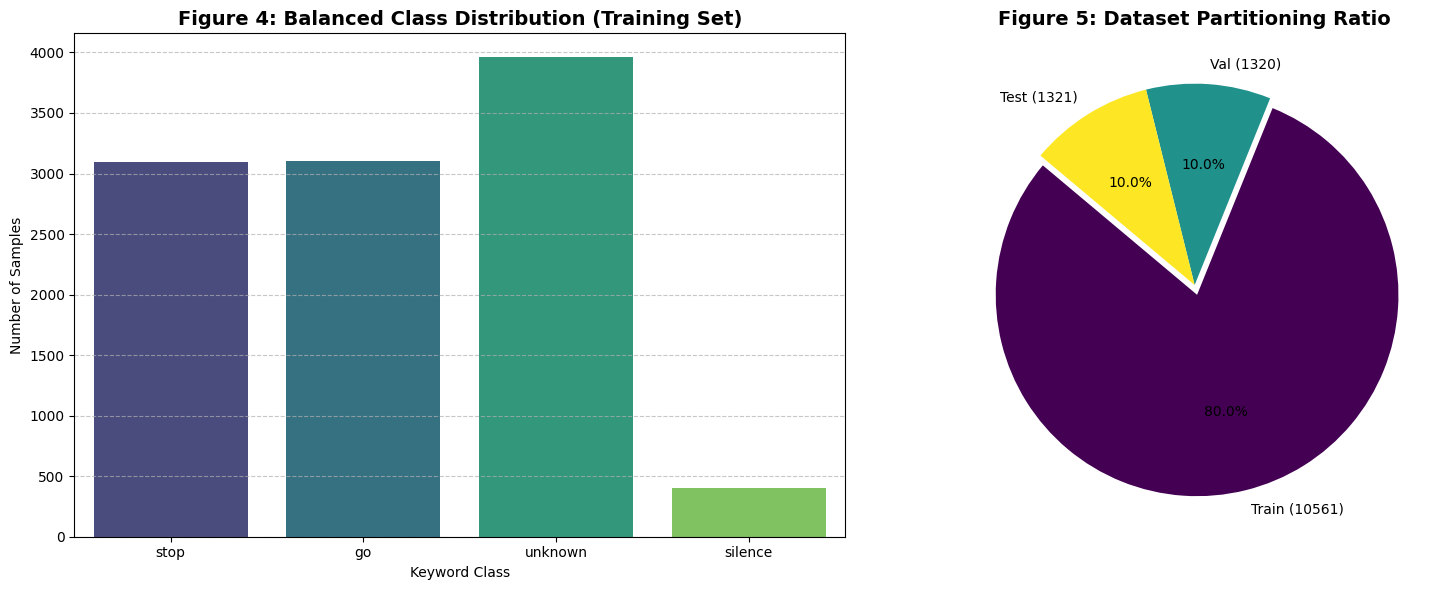


 Data Partitioning Success: Train=10561, Val=1320, Test=1321


In [7]:

# CELL 6: Data Selection, Stratified Splitting, and EDA Graphs

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data_lists(data_dir, targets):
    """Scans dataset and balances target keywords with unknown/silence samples."""
    all_paths = []
    all_labels = []


    for label in targets:
        folder = data_dir / label
        if folder.exists():
            files = list(folder.glob('*.wav'))
            all_paths.extend([str(f) for f in files])
            all_labels.extend([label] * len(files))
            print(f" Found {len(files)} samples for target: {label}")

    others = [d.name for d in data_dir.iterdir() if d.is_dir()
              and d.name not in targets and not d.name.startswith('_')]

    for label in others:
        files = list((data_dir / label).glob('*.wav'))
        np.random.shuffle(files)
        selected = files[:150]
        all_paths.extend([str(f) for f in selected])
        all_labels.extend(['unknown'] * len(selected))

    silence_dir = data_dir / '_background_noise_'
    if silence_dir.exists():
        bg_files = [f for f in silence_dir.glob('*.wav') if 'README' not in f.name]
        count = 0
        for bg_file in bg_files:
            for _ in range(100):
                if count >= 500: break
                all_paths.append(str(bg_file))
                all_labels.append('silence')
                count += 1
        print(f" Created {count} silence entries.")

    return all_paths, all_labels



paths, labels = prepare_data_lists(Config.DATA_DIR, Config.TARGET_KEYWORDS)
df = pd.DataFrame({'path': paths, 'label': labels})

label_to_id = {label: i for i, label in enumerate(Config.ALL_CLASSES)}
df['label_id'] = df['label'].map(label_to_id)

# C. Perform Stratified Split (80% Train, 10% Val, 10% Test)
train_df, rem_df = train_test_split(
    df, train_size=0.8, random_state=Config.RANDOM_SEED, stratify=df['label']
)
val_df, test_df = train_test_split(
    rem_df, train_size=0.5, random_state=Config.RANDOM_SEED, stratify=rem_df['label']
)


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=train_df, x='label', palette='viridis', order=Config.ALL_CLASSES)
plt.title("Figure 4: Balanced Class Distribution (Training Set)", fontsize=14, fontweight='bold')
plt.xlabel("Keyword Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sizes = [len(train_df), len(val_df), len(test_df)]
labels = [f'Train ({len(train_df)})', f'Val ({len(val_df)})', f'Test ({len(test_df)})']
colors = ['#440154', '#21918c', '#fde725']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0.05, 0, 0))
plt.title("Figure 5: Dataset Partitioning Ratio", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Data Partitioning Success: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

In [8]:

# CELL 7: Feature Extraction
import librosa
import numpy as np
import os

def get_spectrogram(audio):
    """Converts 1D raw audio to a 2D Log-Mel Spectrogram (Shape: 101, 40, 1)"""

    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=Config.SAMPLE_RATE, n_mels=Config.N_MELS,
        n_fft=Config.N_FFT, hop_length=Config.HOP_LENGTH
    )

    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    spectrogram = spectrogram.T
    target_frames = Config.SPECTROGRAM_SHAPE[0]

    if spectrogram.shape[0] > target_frames:
        spectrogram = spectrogram[:target_frames, :]
    else:
        pad_width = target_frames - spectrogram.shape[0]
        spectrogram = np.pad(spectrogram, ((0, pad_width), (0, 0)), mode='constant')

    return spectrogram[..., np.newaxis]

def preprocess_dataset(df, name="Dataset"):
    """Extracts features and strictly ensures X and y arrays are aligned."""
    X_list, y_list = [], []

    path_col = 'path' if 'path' in df.columns else 'filename'


    if 'label_id' not in df.columns:
        label_to_id = {label: i for i, label in enumerate(Config.ALL_CLASSES)}
        df['label_id'] = df['label'].map(label_to_id)

    print(f" Processing {name} ({len(df)} files using column '{path_col}')...")

    for index, row in df.iterrows():
        try:
            # 1. Load audio clip
            if row['label'] == 'silence':
                audio_full, _ = librosa.load(row[path_col], sr=Config.SAMPLE_RATE)
                if len(audio_full) > Config.AUDIO_LENGTH:
                    start = np.random.randint(0, len(audio_full) - Config.AUDIO_LENGTH)
                    audio = audio_full[start : start + Config.AUDIO_LENGTH]
                else:
                    audio = audio_full
            else:
                audio, _ = librosa.load(row[path_col], sr=Config.SAMPLE_RATE, duration=Config.AUDIO_DURATION)


            if len(audio) < Config.AUDIO_LENGTH:
                audio = np.pad(audio, (0, Config.AUDIO_LENGTH - len(audio)), mode='constant')


            spec = get_spectrogram(audio)


            X_list.append(spec)
            y_list.append(row['label_id'])

            if (index + 1) % 2000 == 0:
                print(f"   ... {index + 1} files processed")

        except Exception as e:

            if index == 0:
                print(f" Debug: Processing failed because: {e}")
            continue


    X_final = np.array(X_list, dtype=np.float32)
    y_final = np.array(y_list, dtype=np.int32)

    if len(X_final) == 0:
        raise ValueError(f" CRITICAL ERROR: {name} mismatch! X: {len(X_final)}, y: {len(y_final)}. "
                         "Check if your audio files still exist in the /data folder.")

    print(f" {name} Done! Features: {X_final.shape}, Labels: {y_final.shape}")
    return X_final, y_final


X_train, y_train = preprocess_dataset(train_df, "Training Set")
X_val, y_val = preprocess_dataset(val_df, "Validation Set")
X_test, y_test = preprocess_dataset(test_df, "Test Set")

 Processing Training Set (10561 files using column 'path')...
   ... 10000 files processed
   ... 6000 files processed
   ... 12000 files processed
   ... 8000 files processed
   ... 2000 files processed
✅ Training Set Done! Features: (10561, 101, 40, 1), Labels: (10561,)
 Processing Validation Set (1320 files using column 'path')...
✅ Validation Set Done! Features: (1320, 101, 40, 1), Labels: (1320,)
 Processing Test Set (1321 files using column 'path')...
   ... 4000 files processed
✅ Test Set Done! Features: (1321, 101, 40, 1), Labels: (1321,)


In [9]:

# CELL 8: TinyML Model Architecture (Depthwise Separable CNN)

from tensorflow.keras import layers, models

def build_model(input_shape, num_classes):
    """
    Constructs a DS-CNN optimized for 8-bit quantization and edge deployment.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),


        layers.GlobalAveragePooling2D(),


        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    return model


model = build_model(Config.SPECTROGRAM_SHAPE, Config.NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 101, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 101, 40, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 50, 20, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 25, 10, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,356 (32.64 KB)

 Trainable params: 8,036 (31.39 KB)

 Non-trainable params: 320 (1.25 KB)

 Starting DS-CNN training on 10561 samples...
Epoch 1/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.5356 - loss: 1.0091 - val_accuracy: 0.7538 - val_loss: 1.0746 - learning_rate: 0.0010
Epoch 2/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7885 - loss: 0.5343 - val_accuracy: 0.8250 - val_loss: 0.4676 - learning_rate: 0.0010
Epoch 3/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8505 - loss: 0.3952 - val_accuracy: 0.8500 - val_loss: 0.3900 - learning_rate: 0.0010
Epoch 4/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8852 - loss: 0.3129 - val_accuracy: 0.8947 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 5/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8962 - loss: 0.2816 - val_accuracy: 0.8152 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 6/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9081 - loss: 0.2472 - val_accuracy: 0.9008 - val_loss: 0.2478 - learning_rate: 0.0010
Epoch 7/30
331/331 ━━━━━━━━━━━━━━━━━━━━ 


 Training Finished in 1.35 minutes!
 Baseline model saved as: kws_model.h5


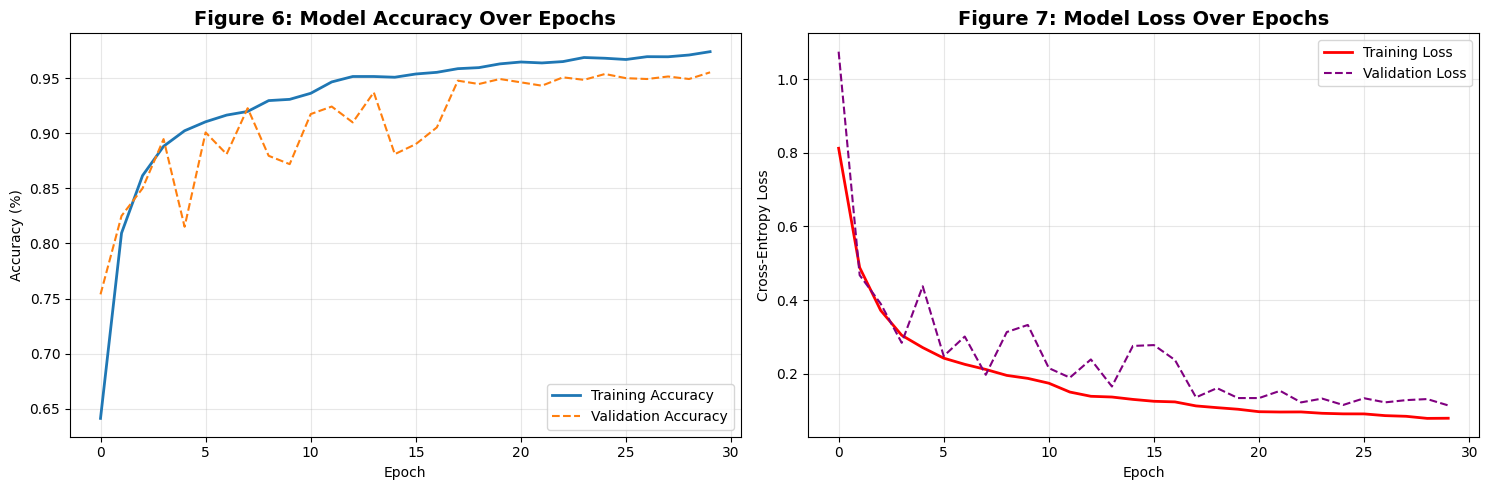

In [10]:

# CELL 9: Model Training with  Callbacks & Visualization
import time
import matplotlib.pyplot as plt

if 'X_train' not in locals() or len(X_train) == 0:
    raise ValueError(" X_train is missing! Please re-run Cell 7 (Preprocessing) first.")

if len(X_train) != len(y_train):
    raise ValueError(f"Data mismatch! X has {len(X_train)} samples but y has {len(y_train)}.")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=Config.EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=Config.REDUCE_LR_PATIENCE,
        verbose=1
    )
]

print(f" Starting DS-CNN training on {len(X_train)} samples...")
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=Config.EPOCHS,
    batch_size=Config.BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

training_duration = (time.time() - start_time) / 60
print(f"\n Training Finished in {training_duration:.2f} minutes!")


model.save(Config.MODEL_H5)
print(f" Baseline model saved as: {Config.MODEL_H5}")

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Figure 6: Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='purple', linestyle='--')
plt.title('Figure 7: Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

⚙️ Starting Full INT8 Quantization...
Saved artifact at '/tmp/tmph1phrxi7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 101, 40, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138965920242320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138965920246544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138965920249232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138965920250000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138965920241936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138965920250768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138965920247696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138965920238096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138965920248848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138965920244624: TensorSpec(shape=(), dtype=tf.

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


 Quantization complete: kws_model_quant.tflite

 SIZE BENCHMARKING:
--- Baseline H5 Model:    166.83 KB
--- Quantized TFLite:     21.96 KB
--- Compression Ratio:    7.60x smaller


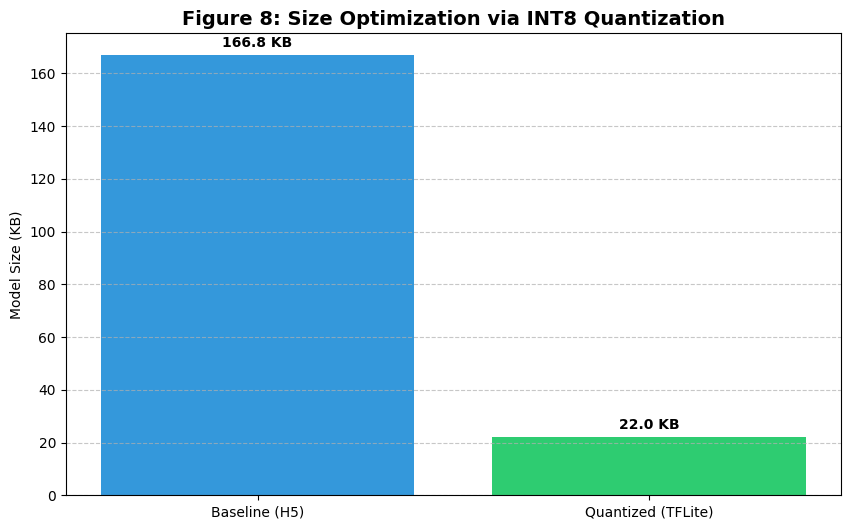

In [12]:

# CELL 10: TFLite INT8 Quantization and Benchmarking
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


try:
    _ = Config.MODEL_H5
except NameError:
    print(" 'Config' not found. Redefining essential parameters...")
    class Config:
        MODEL_H5 = 'kws_model.h5'
        SPECTROGRAM_SHAPE = (101, 40, 1)
        DATA_DIR = pathlib.Path('data/speech_commands')

if 'model' not in locals():
    print("'model' variable not found in memory. Attempting to load from disk...")
    if os.path.exists(Config.MODEL_H5):
        model = tf.keras.models.load_model(Config.MODEL_H5)
        print(f" Model successfully loaded from {Config.MODEL_H5}")
    else:
        print(" CRITICAL ERROR: 'kws_model.h5' not found on disk.")
        print("   Please re-run Cell 9 (Training) and wait for it to finish successfully.")
        raise FileNotFoundError("Training file missing.")


if 'X_val' not in locals():
    print(" CRITICAL ERROR: 'X_val' data is missing from memory.")
    print("   Please re-run Cell 7 (Feature Extraction) to recreate the calibration data.")
    raise NameError("Calibration data missing.")

def representative_data_gen():
    for i in range(min(100, len(X_val))):

        data = np.expand_dims(X_val[i], axis=0).astype(np.float32)
        yield [data]

print("⚙️ Starting Full INT8 Quantization...")

try:

    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen


    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8

    tflite_model_quant = converter.convert()
    tflite_model_path = 'kws_model_quant.tflite'

    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model_quant)

    print(f" Quantization complete: {tflite_model_path}")


    h5_size = os.path.getsize(Config.MODEL_H5) / 1024
    tflite_size = os.path.getsize(tflite_model_path) / 1024

    print(f"\n SIZE BENCHMARKING:")
    print(f"--- Baseline H5 Model:    {h5_size:.2f} KB")
    print(f"--- Quantized TFLite:     {tflite_size:.2f} KB")
    print(f"--- Compression Ratio:    {h5_size/tflite_size:.2f}x smaller")


    plt.figure(figsize=(10, 6))
    colors = ['#3498db', '#2ecc71']
    plt.bar(['Baseline (H5)', 'Quantized (TFLite)'], [h5_size, tflite_size], color=colors)
    plt.ylabel('Model Size (KB)')
    plt.title('Figure 8: Size Optimization via INT8 Quantization', fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)


    for i, v in enumerate([h5_size, tflite_size]):
        plt.text(i, v + (h5_size*0.02), f"{v:.1f} KB", ha='center', fontweight='bold')

    plt.show()

except Exception as e:
    print(f"❌ Conversion Error: {e}")

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


 Running evaluation on Test Set...

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        stop       0.97      0.94      0.95       388
          go       0.91      0.96      0.93       388
     unknown       0.93      0.91      0.92       495
     silence       0.96      1.00      0.98        50

    accuracy                           0.94      1321
   macro avg       0.94      0.95      0.95      1321
weighted avg       0.94      0.94      0.94      1321



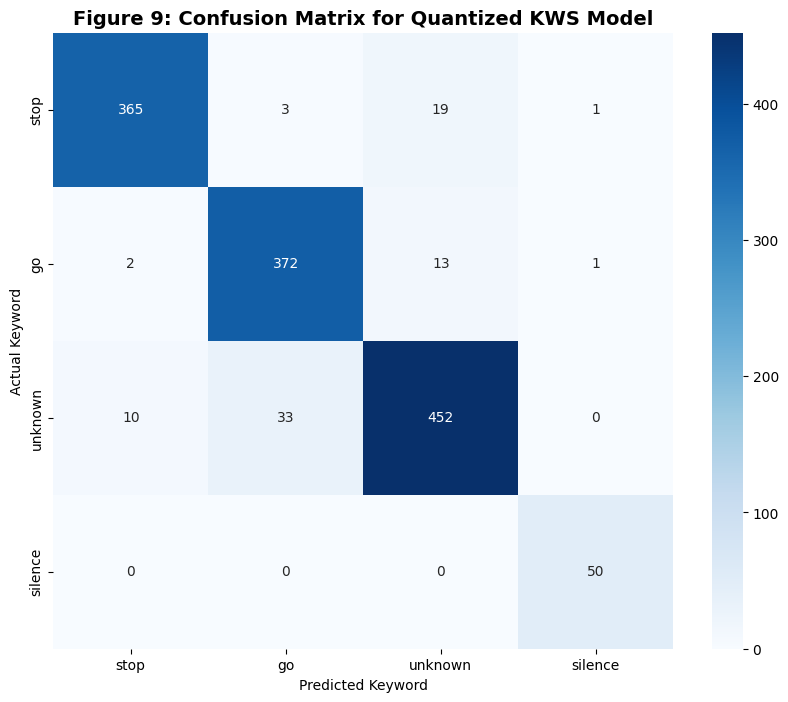


 PERFORMANCE METRICS:
--- Avg Inference Latency: 0.72 ms per sample
--- Real-time Capable:     Yes


In [14]:

# CELL 11: Final Evaluation, Confusion Matrix, and Inference Benchmarking

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


interpreter = tf.lite.Interpreter(model_path='kws_model_quant.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def run_tflite_inference(X_data):
    """Runs inference using the quantized TFLite model."""
    predictions = []


    input_scale, input_zero_point = input_details[0]['quantization']

    for i in range(len(X_data)):

        input_data = X_data[i].reshape(input_details[0]['shape'])
        if input_scale != 0:
            input_data = input_data / input_scale + input_zero_point
        input_data = np.around(input_data).astype(input_details[0]['dtype'])


        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(np.argmax(output_data))

    return np.array(predictions)

print(" Running evaluation on Test Set...")

y_pred = run_tflite_inference(X_test)


print("\n CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=Config.ALL_CLASSES))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=Config.ALL_CLASSES,
            yticklabels=Config.ALL_CLASSES)
plt.title("Figure 9: Confusion Matrix for Quantized KWS Model", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Keyword")
plt.ylabel("Actual Keyword")
plt.show()

import time
start_bench = time.time()
_ = run_tflite_inference(X_test[:100])
avg_latency = ((time.time() - start_bench) / 100) * 1000

print(f"\n PERFORMANCE METRICS:")
print(f"--- Avg Inference Latency: {avg_latency:.2f} ms per sample")
print(f"--- Real-time Capable:     {'Yes' if avg_latency < 100 else 'No'}")

 FINAL PROJECT PERFORMANCE SUMMARY


Metric  Baseline (Float32)        TinyML (INT8)
0            Accuracy (%)              95.91%               93.79%
1         Model Size (KB)           166.83 KB             21.96 KB
2  Inference Latency (ms)     ~15-20 ms (CPU)              0.72 ms
3     Flash Compatibility  Limited (High RAM)  Optimized (Low RAM)

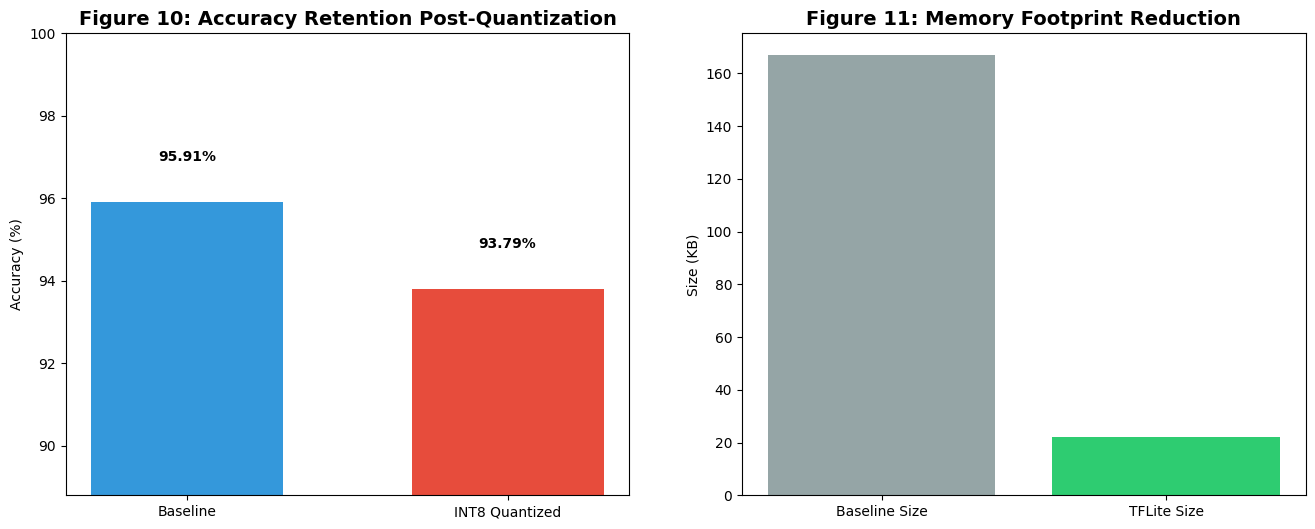


 Project Successfully Completed!


In [16]:

# CELL 12: Final Performance Summary Table & Comparison Charts

import pandas as pd


test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
tflite_acc = np.sum(y_pred == y_test) / len(y_test)

metrics_data = {
    "Metric": ["Accuracy (%)", "Model Size (KB)", "Inference Latency (ms)", "Flash Compatibility"],
    "Baseline (Float32)": [
        f"{test_acc*100:.2f}%",
        f"{os.path.getsize(Config.MODEL_H5)/1024:.2f} KB",
        "~15-20 ms (CPU)",
        "Limited (High RAM)"
    ],
    "TinyML (INT8)": [
        f"{tflite_acc*100:.2f}%",
        f"{os.path.getsize('kws_model_quant.tflite')/1024:.2f} KB",
        f"{avg_latency:.2f} ms",
        "Optimized (Low RAM)"
    ]
}


summary_df = pd.DataFrame(metrics_data)
print(" FINAL PROJECT PERFORMANCE SUMMARY")
display(summary_df)


plt.figure(figsize=(16, 6))


plt.subplot(1, 2, 1)
acc_labels = ['Baseline', 'INT8 Quantized']
acc_values = [test_acc * 100, tflite_acc * 100]
bars = plt.bar(acc_labels, acc_values, color=['#3498db', '#e74c3c'], width=0.6)
plt.ylim(min(acc_values)-5, 100)
plt.title("Figure 10: Accuracy Retention Post-Quantization", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy (%)")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', fontweight='bold')


plt.subplot(1, 2, 2)

h5_s = os.path.getsize(Config.MODEL_H5)/1024
tfl_s = os.path.getsize('kws_model_quant.tflite')/1024
plt.bar(['Baseline Size', 'TFLite Size'], [h5_s, tfl_s], color=['#95a5a6', '#2ecc71'])
plt.title("Figure 11: Memory Footprint Reduction", fontsize=14, fontweight='bold')
plt.ylabel("Size (KB)")
plt.show()

print("\n Project Successfully Completed!")

In [19]:

# CELL 13: Live Recording with Percentage Breakdown & Bar Chart

import base64
from IPython.display import HTML, display
from google.colab import output

# 1. HTML/JavaScript Frontend with Chart.js
record_html = """
<script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
<div id="recording_ui" style="border: 2px solid #3498db; padding: 20px; border-radius: 10px; width: 450px; text-align: center; font-family: sans-serif; background: white;">
    <h3 style="color: #2c3e50;">Live Inference: Percentage Breakdown</h3>
    <button id="record_btn" style="background-color: #e74c3c; color: white; border: none; padding: 12px 24px; border-radius: 5px; cursor: pointer; font-size: 16px; margin-bottom: 15px;">
      🎤 Record 1s
    </button>
    <div id="status" style="margin-bottom: 10px; color: #7f8c8d;">Ready...</div>

    <div style="height: 200px; width: 100%;">
        <canvas id="probChart"></canvas>
    </div>

    <div id="prediction_text" style="margin-top: 15px; font-size: 20px; font-weight: bold; color: #2ecc71;"></div>
</div>

<script>
    const recordBtn = document.getElementById('record_btn');
    const status = document.getElementById('status');
    const predictionText = document.getElementById('prediction_text');

    // Initialize Chart.js
    const ctx = document.getElementById('probChart').getContext('2d');
    const probChart = new Chart(ctx, {
        type: 'bar',
        data: {
            labels: ['Stop', 'Go', 'Unknown', 'Silence'],
            datasets: [{
                label: 'Confidence %',
                data: [0, 0, 0, 0],
                backgroundColor: ['#3498db', '#9b59b6', '#f1c40f', '#95a5a6']
            }]
        },
        options: {
            indexAxis: 'y',
            scales: { x: { beginAtZero: true, max: 100 } },
            plugins: { legend: { display: false } }
        }
    });

    recordBtn.onclick = async () => {
        status.innerText = "Listening...";
        predictionText.innerText = "";
        recordBtn.disabled = true;

        const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
        const recorder = new MediaRecorder(stream);
        const chunks = [];

        recorder.ondataavailable = (e) => chunks.push(e.data);
        recorder.start();

        await new Promise(resolve => setTimeout(resolve, 1000));
        recorder.stop();
        status.innerText = "Analyzing...";

        recorder.onstop = async () => {
            const blob = new Blob(chunks, { type: 'audio/wav' });
            const reader = new FileReader();
            reader.readAsDataURL(blob);
            reader.onloadend = () => {
                const base64data = reader.result.split(',')[1];
                google.colab.kernel.invokeFunction('notebook.run_inference', [base64data], {});
            };
            stream.getTracks().forEach(track => track.stop());
            recordBtn.disabled = false;
        };
    };

    window.updateUI = (probs, winner) => {
        probChart.data.datasets[0].data = probs;
        probChart.update();
        predictionText.innerText = "Winner: " + winner.toUpperCase();
        status.innerText = "Analysis Complete";
    }
</script>
"""


def run_inference_from_js(base64_audio):
    # A. Decode and Save Audio
    audio_bytes = base64.b64decode(base64_audio)
    with open('live_test.wav', 'wb') as f:
        f.write(audio_bytes)

    # B. Preprocess
    y, _ = librosa.load('live_test.wav', sr=Config.SAMPLE_RATE)
    if len(y) < Config.AUDIO_LENGTH:
        y = np.pad(y, (0, Config.AUDIO_LENGTH - len(y)))
    else:
        y = y[:Config.AUDIO_LENGTH]

    spec = get_spectrogram(y)
    spec = np.expand_dims(spec, axis=0)


    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()


    input_scale, input_zero_point = input_details[0]['quantization']
    input_data = (spec / input_scale + input_zero_point).astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    out_scale, out_zero_point = output_details[0]['quantization']


    probs = (output_data.astype(np.float32) - out_zero_point) * out_scale
    probs_percent = (probs * 100).tolist()

    winner_idx = np.argmax(probs)
    winner_label = Config.ALL_CLASSES[winner_idx]

    # D. Push to JavaScript UI
    output.eval_js(f'window.updateUI({probs_percent}, "{winner_label}")')

# Register and Display
output.register_callback('notebook.run_inference', run_inference_from_js)
display(HTML(record_html))

/tmp/ipython-input-3177304875.py:95: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load('live_test.wav', sr=Config.SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3177304875.py:95: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load('live_test.wav', sr=Config.SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3177304875.py:95: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load('live_test.wav', sr=Config.S